## Understanding word embeddings
Deep neural network models, including LLMs, cannot process raw text directly. Since text is
categorical, it isn't compatible with the mathematical operations used to implement and
train neural networks.
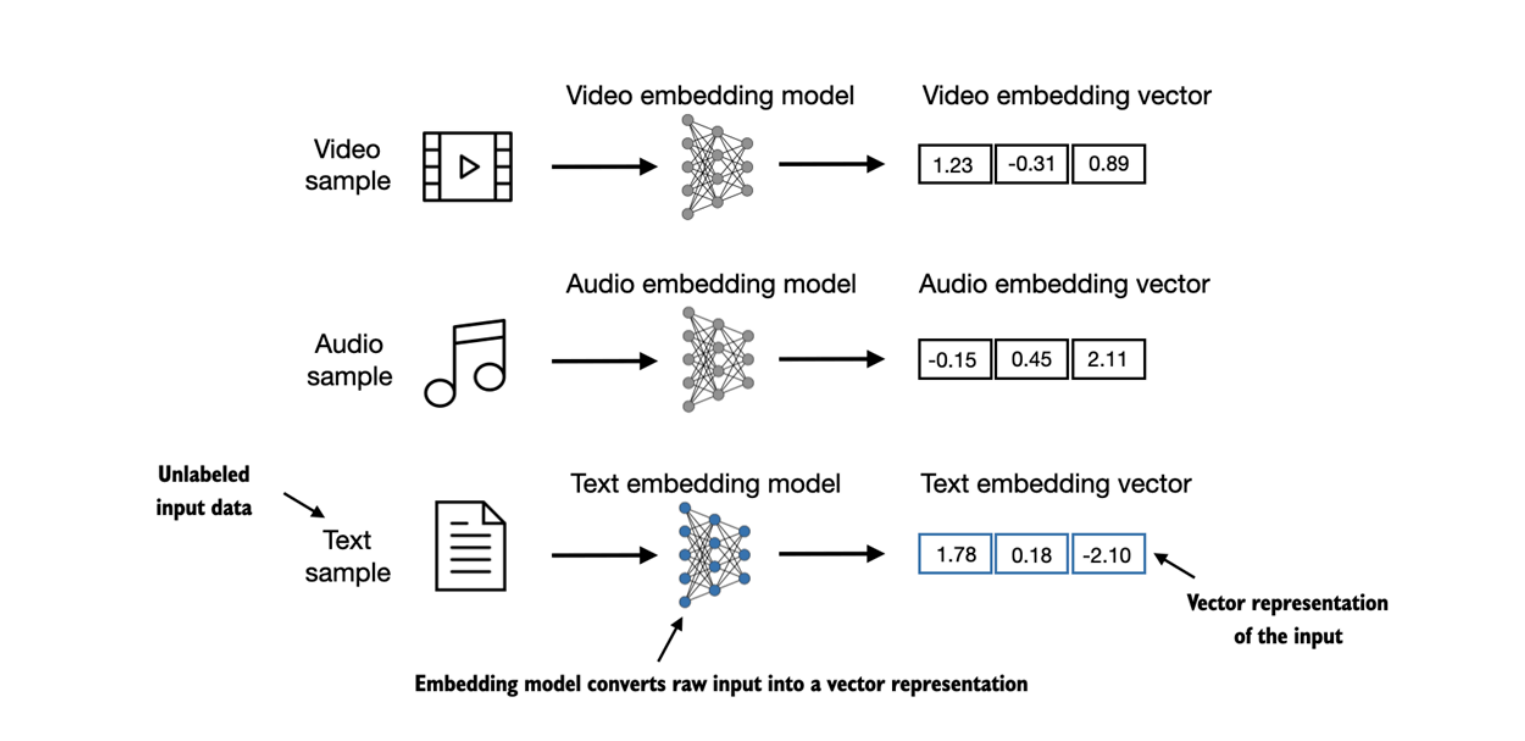

## Tokenizing text
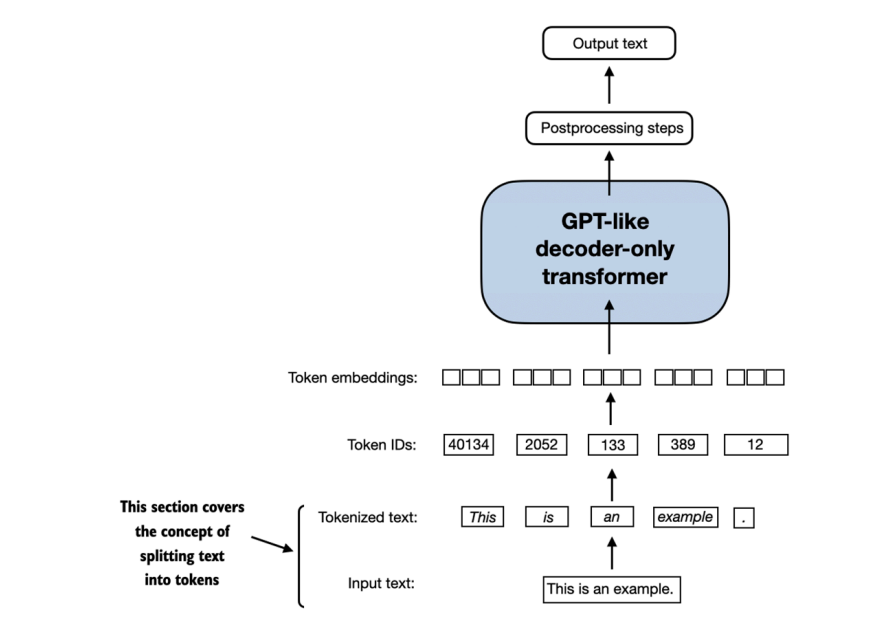

In [2]:
with open("../data/raw/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### Cleaning the RAW text

In [3]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [7]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [8]:
# need to remove whitespace characters
result = [item for item in result if item.strip()]
print(result)


['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


The tokenization scheme we devised above works well on the simple sample text. Let's
modify it a bit further so that it can also handle other types of punctuation, such as
question marks, quotation marks, and the double-dashes we have seen earlier in the first
100 characters of Edith Wharton's short story, along with additional special characters:

In [10]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


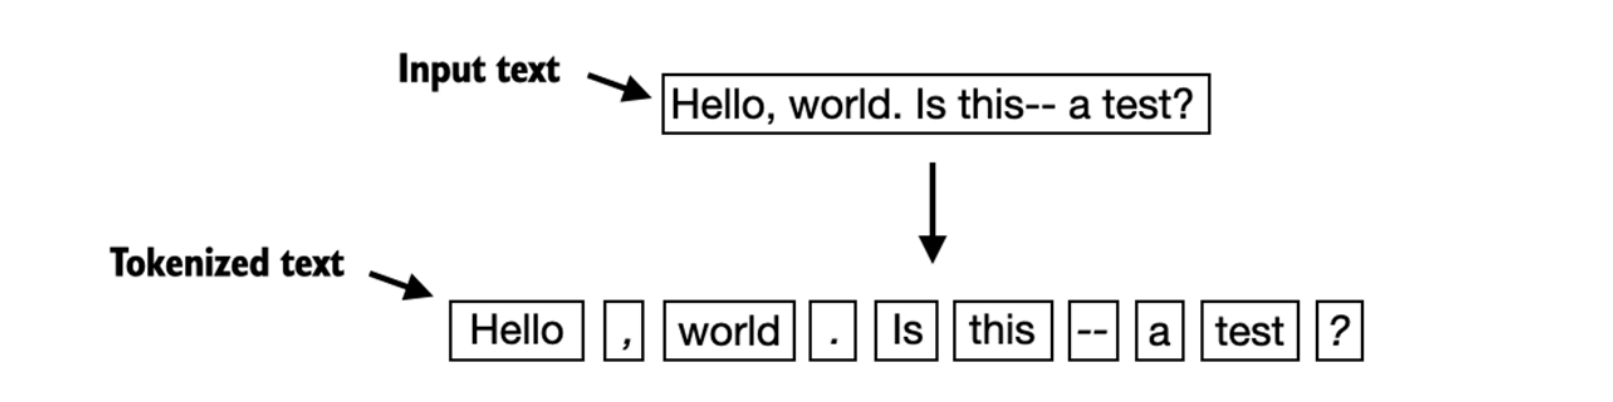

### Now we are moving to our raw_text

In [11]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [12]:
preprocessed[:10]

['I',
 'HAD',
 'always',
 'thought',
 'Jack',
 'Gisburn',
 'rather',
 'a',
 'cheap',
 'genius']

## Converting tokens into token IDs

**Token IDs** are the numerical representations of tokens, created by mapping each unique token to a unique integer.
After text is split into tokens, these IDs allow the model to process language as numbers, which is required for embeddings, training, and computation.
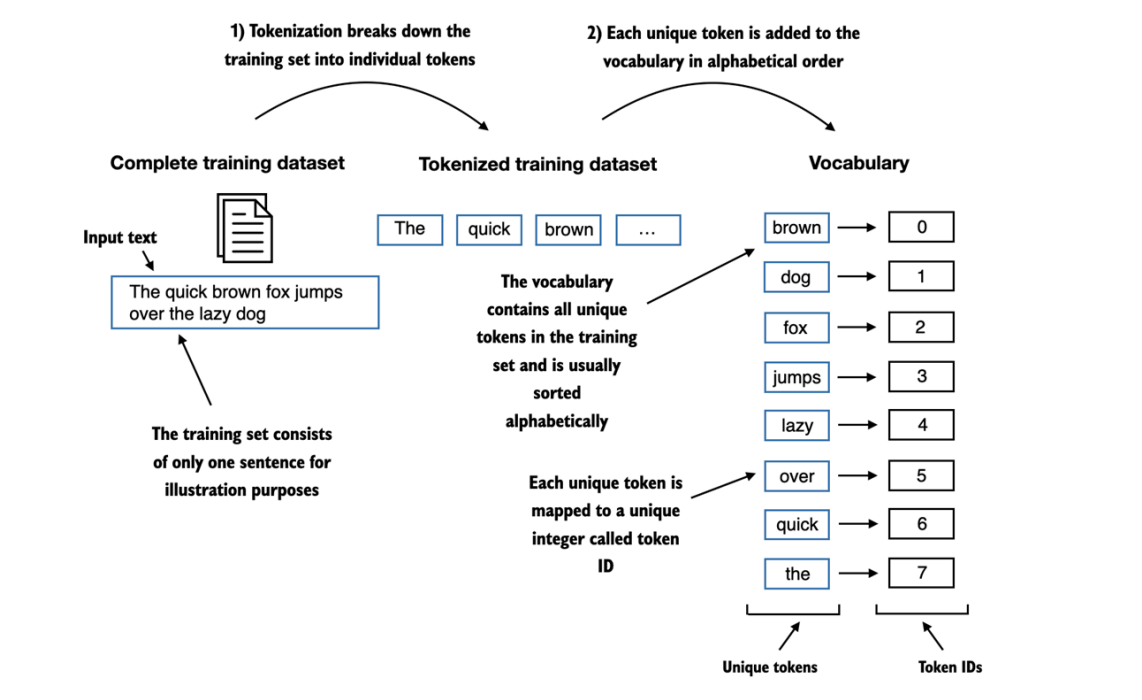

In [13]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [14]:
all_words[:10]

['!', '"', "'", '(', ')', ',', '--', '.', ':', ';']

In [17]:
vocab = {token:integer for integer,token in enumerate(all_words)}
# vocab

In [18]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)
('His', 51)


## SimpleTokenizerV1
complete tokenizer class in Python with an encode method that splits
text into tokens and carries out the string-to-integer mapping to produce token IDs via the
vocabulary. In addition, we implement a decode method that carries out the reverse
integer-to-string mapping to convert the token IDs back into text.


In [20]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab # Store the vocabulary as a class attribute for access in the encode and decode methods
        self.int_to_str = {i:s for s,i in vocab.items()} # Create an inverse vocabulary that maps token IDs back to the original text tokens
    def encode(self, text): # Process input text into token IDs
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    def decode(self, ids): #  Convert token IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #  Replace spaces before the specified punctuation
        return text

In [22]:
# vocab

In [23]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," Mrs. Gisburn said with pardonable
pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [26]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


The problem is that the word "Hello" was not used in the The Verdict short story. Hence, it
is not contained in the vocabulary. This highlights the need to consider large and diverse
training sets to extend the vocabulary when working on LLMs.

In [27]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

## SimpleTokenizerV2
we will modify this tokenizer to handle unknown words.
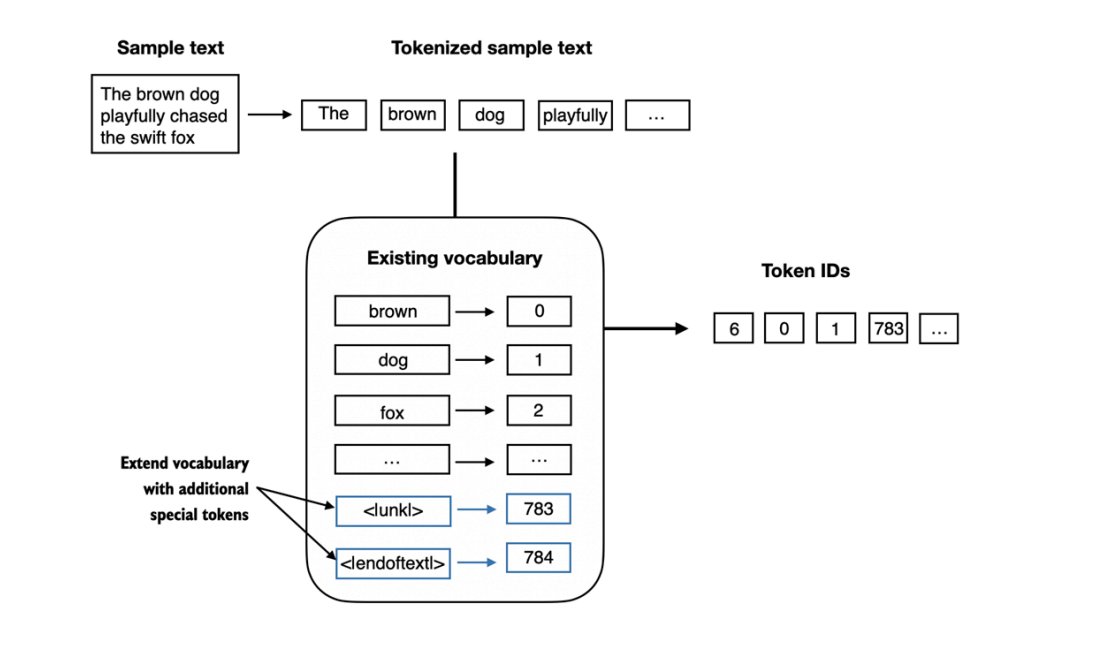

In [28]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))

1132


In [32]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int #A
    else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #B
        return text

In [29]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [30]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)


Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [33]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))


[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [34]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## Byte pair encoding
usage of this tokenizer is similar to SimpleTokenizerV2

In [35]:
pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.12.0


In [37]:
tokenizer = tiktoken.get_encoding("gpt2")

In [39]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [40]:
tokenizer.decode(integers)

'Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.'